# DeepGL - Deep Feature Learning for graphs

We've implemented the [DeepGL](https://arxiv.org/abs/1704.08829) algorithm as a Neo4j procedure and this notebook shows our experiments with it against a SNAP email dataset.

First up let's import some things...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import pandas as pd
from neo4j.v1 import GraphDatabase
import tensorflow as tf


# load data
from sklearn.preprocessing import StandardScaler

In [52]:
driver = GraphDatabase.driver("bolt://localhost", auth=("neo4j", "neo"))

Time to load our data into Neo4j.

In [4]:
edge_list_file = "https://github.com/meltzerpete/Embedding-Vis/raw/master/emails/emails.edgelist"
labels_file = "https://github.com/meltzerpete/Embedding-Vis/raw/master/emails/emails.labels"
attributes_file = None

with driver.session() as session:
    session.run("CREATE CONSTRAINT ON (n:Node) ASSERT n.id IS UNIQUE")
    
    result = session.run("""\
        LOAD CSV FROM $edgelistFile AS row
        FIELDTERMINATOR " "
        MERGE (e1:Node {id: row[0]})
        MERGE (e2:Node {id: row[1]})
        MERGE (e1)-[:LINK]->(e2)
        """, {"edgelistFile": edge_list_file})
    print(result.summary().counters)

    result = session.run("""\
        LOAD CSV FROM $labelsFile AS row
        FIELDTERMINATOR " "
        MATCH (e:Node {id: row[0]})
        SET  e.label = toInteger(row[1])-1
        """, {"labelsFile": labels_file})
    print(result.summary().counters)

    if attributes_file is not None:
        result = session.run("""\
            load csv from $attributesFile  as row
            FIELDTERMINATOR " "
            with toString(toInteger(row[0])) AS nodeId, row[1..] AS properties
            MATCH (s:Node {id: nodeId})
            WITH s, properties
            UNWIND range(0, size(properties)-1) AS index
            CALL apoc.create.setProperty(s, "property_" + index, toFloat(properties[index])) YIELD node
            return count(*)
            """, {"attributesFile": attributes_file})
        print(result.summary().counters)

{'labels_added': 1005, 'nodes_created': 1005, 'properties_set': 1005, 'relationships_created': 25571}
{'properties_set': 1005}


In [53]:
embedding_property_name = "embedding_python_iter_3"
node_features = []
pruning_lambda = 0.6
diffusions = 3
iterations = 3

In [54]:
with driver.session() as session:
    params = {
        "writeProperty": embedding_property_name,
        "nodeFeatures": node_features,
        "pruningLambda": pruning_lambda,
        "diffusions": diffusions,
        "iterations": iterations
    }
    result = session.run("""
    call
    algo.deepgl(
        null,
        null,
        
        {nodeFeatures: $nodeFeatures,
         pruningLambda: $pruningLambda,
         diffusions: $diffusions,
         iterations: $iterations,
         writeProperty: $writeProperty})
    """, params)
    print(result.peek())

<Record loadMillis=104 computeMillis=376989 writeMillis=248 nodes=1005 writeProperty=u'embedding_python_iter_3' embeddingSize=408 numberOfLayers=4 features=[u'max_in_neighbourhood( diffuse( rbf_out_neighbourhood( rbf_in_neighbourhood( IN_DEGREE))))', u'max_in_neighbourhood( diffuse( hadamard_out_neighbourhood( mean_in_neighbourhood( IN_DEGREE))))', u'max_in_neighbourhood( diffuse( rbf_out_neighbourhood( diffuse( rbf_in_neighbourhood( IN_DEGREE)))))', u'max_in_neighbourhood( sum_in_neighbourhood( diffuse( rbf_out_neighbourhood( IN_DEGREE))))', u'max_out_neighbourhood( mean_out_neighbourhood( IN_DEGREE))', u'max_out_neighbourhood( diffuse( hadamard_in_neighbourhood( IN_DEGREE)))', u'max_in_neighbourhood( max_in_neighbourhood( diffuse( hadamard_out_neighbourhood( OUT_DEGREE))))', u'max_in_neighbourhood( max_in_neighbourhood( rbf_in_neighbourhood( IN_DEGREE)))', u'max_in_neighbourhood( max_in_neighbourhood( IN_DEGREE))', u'diffuse( mean_in_neighbourhood( max_in_neighbourhood( rbf_in_neighb

In [33]:
with driver.session() as session:
    result = session.run("""\
    MATCH (n) 
    WITH n.label as class, count(*) AS c
    ORDER BY c DESC
    WITH class WHERE c > 50
    WITH class ORDER BY class
    with collect(class) AS biggestClasses
    MATCH (p:Node) WHERE p.label IN biggestClasses
    SET p.mlLabel = apoc.coll.indexOf(biggestClasses, p.label)
    """)

In [55]:
with driver.session() as session:
    result = session.run("""\
    MATCH (n) 
    WITH n.label as class, count(*) AS c
    ORDER BY c DESC
    WITH class WHERE c > 50
    WITH class ORDER BY class
    with collect(class) AS biggestClasses
    MATCH (p:Node) WHERE p.label IN biggestClasses
    RETURN p.`%s` AS embedding, apoc.coll.indexOf(biggestClasses, p.label) AS label, p.label as initialLabel
    ORDER BY label
    """ % embedding_property_name)

    df = pd.DataFrame(dict(row) for row in result)

emb = df["embedding"].apply(pd.Series).values
labels = df["label"].values

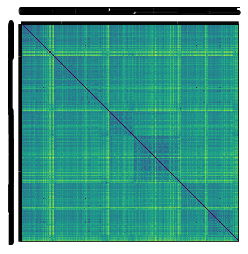

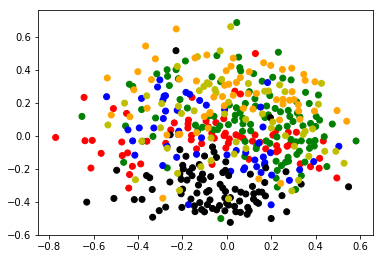

In [56]:
# Heatmap
colours = ['r', 'g', 'b', 'black', 'y', 'orange']
cols = pd.DataFrame(labels).apply(lambda x: colours[int(x)], axis=1).values

dist = np.ndarray([len(emb), len(emb)])

for i, e1 in enumerate(emb):
    for j, e2 in enumerate(emb):
        dist.itemset((i, j), np.linalg.norm(e1 - e2, 2))

plt.imshow(dist)
plt.axes().xaxis.tick_top()
plt.xticks(np.arange(len(dist)), labels)
plt.yticks(np.arange(len(dist)), labels)
plt.show()

# 2D Visualisation
# from: https://baoilleach.blogspot.com/2014/01/convert-distance-matrix-to-2d.html
adist = dist
amax = np.amax(adist)
adist /= amax

mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(adist)

coords = results.embedding_

plt.subplots_adjust(bottom=0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker='o', c=cols
)

plt.show()

In [57]:
X = pd.DataFrame(emb)
y = labels

X = StandardScaler().fit_transform(X)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=.4, random_state=42)

clf = MLPClassifier(solver='sgd',
                    activation='tanh',
                    learning_rate_init=0.001,
                    alpha=1e-5,
                    hidden_layer_sizes=(30, 30),
                    max_iter=10000,
                    batch_size=X.shape[0],
                    random_state=0)

clf.n_outputs_ = 6
clf.out_activation_ = "softmax"
print(clf.get_params())
clf.fit(train_x, train_y)

mean_acc = clf.score(test_x, test_y)
print(mean_acc)

{'beta_1': 0.9, 'warm_start': False, 'beta_2': 0.999, 'shuffle': True, 'verbose': False, 'nesterovs_momentum': True, 'hidden_layer_sizes': (30, 30), 'epsilon': 1e-08, 'activation': 'tanh', 'max_iter': 10000, 'batch_size': 433, 'power_t': 0.5, 'random_state': 0, 'learning_rate_init': 0.001, 'tol': 0.0001, 'validation_fraction': 0.1, 'alpha': 1e-05, 'solver': 'sgd', 'momentum': 0.9, 'learning_rate': 'constant', 'early_stopping': False}
0.896551724137931


In [59]:
with driver.session() as session:
    result = session.run("""\
    MATCH (n:Node) 
    WITH n.label as class, count(*) AS c
    ORDER BY c DESC
    WITH class WHERE c > 50 
    with collect(class) AS biggestClasses
    MATCH (n:Node) WHERE n.label IN biggestClasses
    RETURN n.%s AS embedding, n.mlLabel AS label, id(n) AS nodeId
    """ %(embedding_property_name))
    
    for row in result:
        prediction = clf.predict(np.array([row["embedding"]]))[0]
        params = {"nodeId": row["nodeId"], "prediction": int(prediction)}
        session.run("""\
        MATCH (n) WHERE id(n) = toInteger($nodeId)
        SET n.prediction = $prediction
        """, params)


In [61]:
with driver.session() as session:
    result = session.run("""\
    MATCH (n) 
    WHERE exists(n.mlLabel)
    RETURN n.mlLabel = n.prediction AS correct, count(*) AS count
    """)
    for row in result:
        print(row)

<Record correct=False count=41>
<Record correct=True count=392>


In [39]:
learning_rate = 0.1
num_steps = 1000
batch_size = 128
display_step = 100

n_hidden_1 = 30 # 1st layer number of neurons
n_hidden_2 = 30 # 2nd layer number of neurons
num_input = 18 
num_classes = 8 

def neural_net(x_dict):
    x = x_dict['emb']
    layer_1 = tf.layers.dense(x, n_hidden_1, activation=tf.nn.tanh)
    layer_2 = tf.layers.dense(layer_1, n_hidden_2, activation=tf.nn.tanh)
    out_layer = tf.layers.dense(layer_2, num_classes)
    return out_layer


def model_fn(features, labels, mode):
    logits = neural_net(features)

    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)

    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())

    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [40]:
emb = StandardScaler().fit_transform(emb)

X_train, X_test, y_train, y_test = train_test_split(emb, labels, test_size=0.33, random_state=42)

In [41]:
model = tf.estimator.Estimator(model_fn)

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'emb': X_train}, y=y_train,
    batch_size=batch_size, num_epochs=None, shuffle=True)

model.train(input_fn, steps=num_steps)

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'emb': X_test}, y=y_test,
    batch_size=batch_size, shuffle=True)

e = model.evaluate(input_fn)

print("Testing Accuracy:", e['accuracy'])

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe52d540bd0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmpaQt9oM', '_train_distribute': None, '_save_summary_steps': 100}


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe52d540bd0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmpaQt9oM', '_train_distribute': None, '_save_summary_steps': 100}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpaQt9oM/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpaQt9oM/model.ckpt.


INFO:tensorflow:loss = 2.4602134061468455, step = 1


INFO:tensorflow:loss = 2.4602134061468455, step = 1


INFO:tensorflow:global_step/sec: 371.675


INFO:tensorflow:global_step/sec: 371.675


INFO:tensorflow:loss = 0.07398043352436251, step = 101 (0.272 sec)


INFO:tensorflow:loss = 0.07398043352436251, step = 101 (0.272 sec)


INFO:tensorflow:global_step/sec: 322.78


INFO:tensorflow:global_step/sec: 322.78


INFO:tensorflow:loss = 0.054314785354942656, step = 201 (0.310 sec)


INFO:tensorflow:loss = 0.054314785354942656, step = 201 (0.310 sec)


INFO:tensorflow:global_step/sec: 325.023


INFO:tensorflow:global_step/sec: 325.023


INFO:tensorflow:loss = 0.04926311212110884, step = 301 (0.308 sec)


INFO:tensorflow:loss = 0.04926311212110884, step = 301 (0.308 sec)


INFO:tensorflow:global_step/sec: 350.642


INFO:tensorflow:global_step/sec: 350.642


INFO:tensorflow:loss = 0.034887904130715755, step = 401 (0.285 sec)


INFO:tensorflow:loss = 0.034887904130715755, step = 401 (0.285 sec)


INFO:tensorflow:global_step/sec: 319.844


INFO:tensorflow:global_step/sec: 319.844


INFO:tensorflow:loss = 0.04051363217077504, step = 501 (0.313 sec)


INFO:tensorflow:loss = 0.04051363217077504, step = 501 (0.313 sec)


INFO:tensorflow:global_step/sec: 322.515


INFO:tensorflow:global_step/sec: 322.515


INFO:tensorflow:loss = 0.00637824655601814, step = 601 (0.310 sec)


INFO:tensorflow:loss = 0.00637824655601814, step = 601 (0.310 sec)


INFO:tensorflow:global_step/sec: 328.567


INFO:tensorflow:global_step/sec: 328.567


INFO:tensorflow:loss = 0.005250448495018942, step = 701 (0.304 sec)


INFO:tensorflow:loss = 0.005250448495018942, step = 701 (0.304 sec)


INFO:tensorflow:global_step/sec: 380.746


INFO:tensorflow:global_step/sec: 380.746


INFO:tensorflow:loss = 0.020480176110294537, step = 801 (0.262 sec)


INFO:tensorflow:loss = 0.020480176110294537, step = 801 (0.262 sec)


INFO:tensorflow:global_step/sec: 374.449


INFO:tensorflow:global_step/sec: 374.449


INFO:tensorflow:loss = 0.022883400063808217, step = 901 (0.267 sec)


INFO:tensorflow:loss = 0.022883400063808217, step = 901 (0.267 sec)


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmpaQt9oM/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmpaQt9oM/model.ckpt.


INFO:tensorflow:Loss for final step: 0.019482849314536733.


INFO:tensorflow:Loss for final step: 0.019482849314536733.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2018-07-23-11:30:46


INFO:tensorflow:Starting evaluation at 2018-07-23-11:30:46


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpaQt9oM/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmpaQt9oM/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2018-07-23-11:30:46


INFO:tensorflow:Finished evaluation at 2018-07-23-11:30:46


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.90909094, global_step = 1000, loss = 0.33728713


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.90909094, global_step = 1000, loss = 0.33728713


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpaQt9oM/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpaQt9oM/model.ckpt-1000


('Testing Accuracy:', 0.90909094)
